Nama : Roni Merdiansah

Untuk dataset yang digunakan sudah melalui proses `train_test_split` sehingga sudah terdapat folder untuk training dan validation, hanya tinggal melanjutkan proses augmentation, melatih dan evaluasi data, serta melabeli data secara otomatis

Data juga sudah memenuhi kriteria kurang lebih 80% train set dan 20% test set

---

Link dataset :
https://www.kaggle.com/datasets/junkal/flowerdatasets

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ronimerdiansah","key":"348f3c0ae2b3fdaae4760582c857b6e3"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d junkal/flowerdatasets

 99% 532M/536M [00:04<00:00, 143MB/s]
100% 536M/536M [00:04<00:00, 139MB/s]


In [5]:
!mkdir flowerdatasets
!unzip flowerdatasets.zip -d flowerdatasets
!ls flowerdatasets

Streaming output truncated to the last 5000 lines.
  inflating: flowerdatasets/flowers/train/rose/37135456215_8ee0e71fbc_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37209953126_87b1ddff10_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37216485931_0e0d232fcd_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37236772855_eb2f32b1af_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37421104851_9f66cda177_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37451725494_21db5e7ea8_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37526965574_ae6b1159bf_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/37537007156_07aaad7f31_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/3769935473_4a141ee8e8_o.jpg  
  inflating: flowerdatasets/flowers/train/rose/37867371406_89de9f78d4_k.jpg  
  inflating: flowerdatasets/flowers/train/rose/3792450522_0df34f72ba_o.jpg  
  inflating: flowerdatasets/flowers/train/rose/38039351116_d2e58ab616_k.jpg  
  inflating: fl

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import zipfile,os,shutil

In [7]:
train_dir = os.path.join('/content/flowerdatasets/flowers/train')
valid_dir = os.path.join('/content/flowerdatasets/flowers/val')

In [19]:
os.listdir(train_dir)

['daisy', 'rose', 'lily', 'orchid', 'dandelion', 'tulip', 'sunflower']

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    validation_split = 0.2,
    fill_mode = 'nearest',
)
test_datagen = ImageDataGenerator(
    rescale = 1./225
    # rotation_range = 20,
    # horizontal_flip = True,
    # vertical_flip = True,
    # shear_range = 0.2,
    # validation_split = 0.2,
    # fill_mode = 'nearest'
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size= 32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 8069 images belonging to 7 classes.
Found 2306 images belonging to 7 classes.


Saat dijumlah total data image adalah 10.375

---

Bila dikalikan 80% maka hasilnya adalah 8300

Bila dikalikan 20% maka hasilnya adalah 2075

---
Hasil yang didapatkan tidak terlalu jauh perbedaannya, sehingga dapat disimpulkan bahwa data train dan validation sudah sesuai ketetuan 80% dan 20%

*(saya sudah melakukan survei sebelumnya bahwa jumlah persentase data saat melakukan `train_test_split` hasilnya tidak sama persis dengan kalkulator)*




In [11]:
#Menggunakan model CNN & Layer Max Pooling
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation= 'relu'),
  tf.keras.layers.Dense(7, activation= 'softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dropout_1 (Dropout)         (None, 82944)            

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92): #artinya berhenti bila nilai lebih dari 92%
      print("\nAkurasi di atas 92%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = 252, # 8069 images = batch_size(32) * steps(252)
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = 72, # 2306 images = batch_size(32) * steps(72)
    verbose =2,
    callbacks=[callbacks]
)

Epoch 1/50
252/252 - 341s - loss: 0.7457 - accuracy: 0.7485 - val_loss: 0.6311 - val_accuracy: 0.8016 - 341s/epoch - 1s/step
Epoch 2/50
252/252 - 337s - loss: 0.5395 - accuracy: 0.8162 - val_loss: 0.4913 - val_accuracy: 0.8359 - 337s/epoch - 1s/step
Epoch 3/50
252/252 - 336s - loss: 0.4498 - accuracy: 0.8483 - val_loss: 0.5235 - val_accuracy: 0.8333 - 336s/epoch - 1s/step
Epoch 4/50
252/252 - 337s - loss: 0.3843 - accuracy: 0.8699 - val_loss: 0.4923 - val_accuracy: 0.8546 - 337s/epoch - 1s/step
Epoch 5/50
252/252 - 338s - loss: 0.3153 - accuracy: 0.8920 - val_loss: 0.4008 - val_accuracy: 0.8802 - 338s/epoch - 1s/step
Epoch 6/50
252/252 - 336s - loss: 0.2906 - accuracy: 0.9018 - val_loss: 0.4018 - val_accuracy: 0.8859 - 336s/epoch - 1s/step
Epoch 7/50
252/252 - 338s - loss: 0.2519 - accuracy: 0.9149 - val_loss: 0.4414 - val_accuracy: 0.8637 - 338s/epoch - 1s/step
Epoch 8/50
252/252 - 337s - loss: 0.2342 - accuracy: 0.9210 - val_loss: 0.3739 - val_accuracy: 0.8971 - 337s/epoch - 1s/step


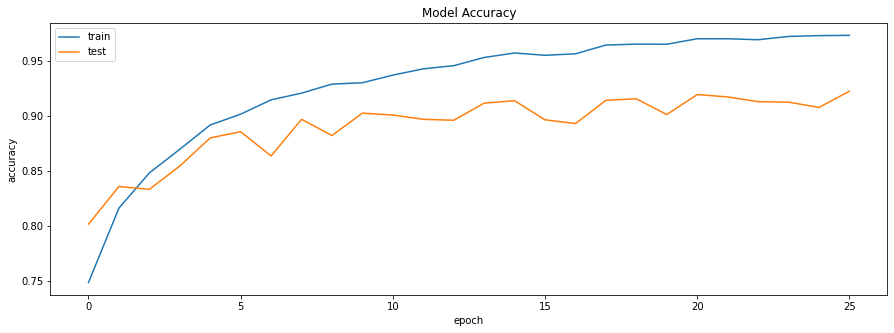

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

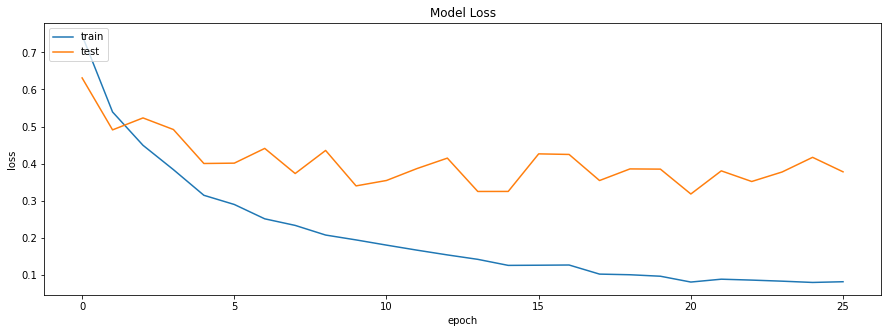

In [18]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('flowers.tflite')
tflite_model_file.write_bytes(tflite_model)

42552088

Saving 10259147356_388a0038da_o.jpg to 10259147356_388a0038da_o (3).jpg
10259147356_388a0038da_o.jpg
orchid


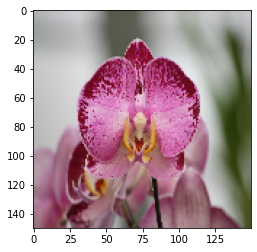

In [26]:
# #main driver
# import numpy as np
# from google.colab import files
# from keras.preprocessing import image
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# %matplotlib inline

# uploaded = files.upload()

# for fn in uploaded.keys():

#   path = fn 
#   img = image.load_img(path, target_size =(150,150))
#   imgplot = plt.imshow(img)
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)

#   print(fn)
#   if classes[0,1]!=0:
#     print('daisy')
#   elif classes[0,2]!=0:
#     print('rose')
#   elif classes[0,3]!=0:
#     print('lily')
#   elif classes[0,4]!=0:
#     print('orchid')
#   elif classes[0,5]!=0:
#     print('dandelion')
#   elif classes[0,6]!=0:
#     print('tulip')
#   elif classes[0,7]!=0:
#     print('sunflower')

  
# # ['daisy', 'rose', 'lily', 'orchid', 'dandelion', 'tulip', 'sunflower']